# EdgeNeXt on CIFAR10

According to [arXiv:2206.10589 [cs.CV]](https://arxiv.org/abs/2206.10589)

Original implementation in https://github.com/mmaaz60/EdgeNeXt

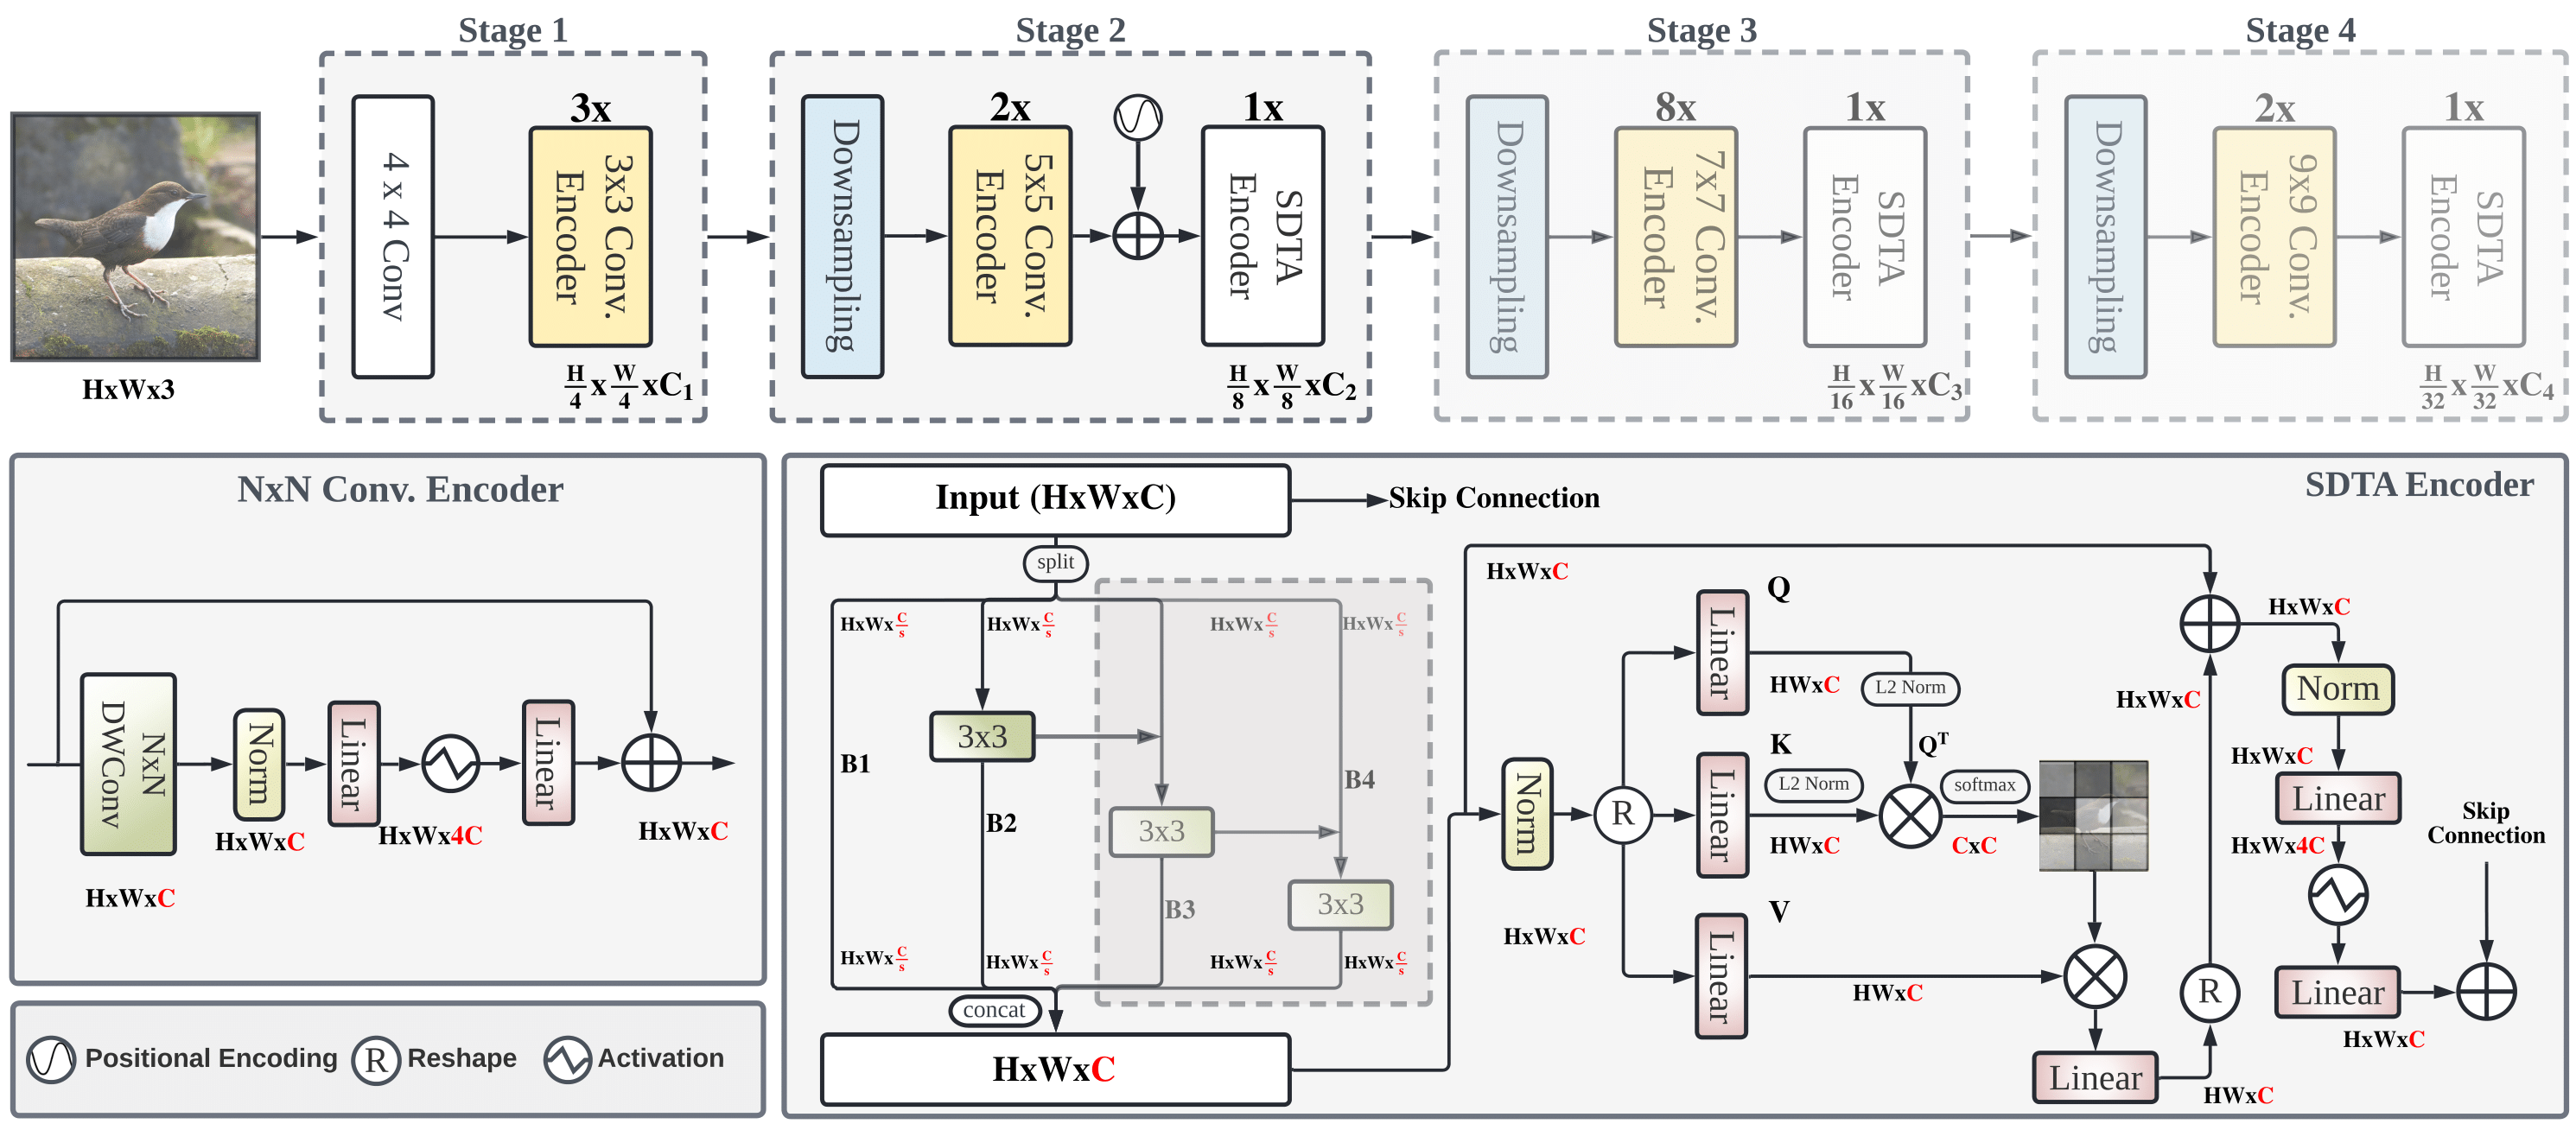

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

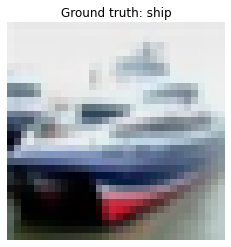

In [7]:
dataset_show_image(test_dset, 1)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Model

Utilities

In [9]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [10]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

Convolutional Encoder

In [11]:
def SpatialMixer(channels, kernel_size, stride=1):
    padding = (kernel_size - 1) // 2
    return nn.Conv2d(channels, channels, kernel_size, padding=padding, stride=stride, groups=channels)

In [12]:
class ChannelMixer(nn.Sequential):
    def __init__(self, channels, mult=4):
        mid_channels = channels * mult
        super().__init__(
            LayerNormChannels(channels),
            nn.Conv2d(channels, mid_channels, 1),
            nn.GELU(),
            nn.Conv2d(mid_channels, channels, 1)
        )

In [13]:
class ConvEncoder(Residual):
    def __init__(self, channels, kernel_size, p_drop=0.):
        super().__init__(
            SpatialMixer(channels, kernel_size),
            ChannelMixer(channels),
            nn.Dropout(p_drop)
        )

SDTA Encoder

Cross-covariance attention (XCA), [arXiv:2106.09681 [cs.CV]](https://arxiv.org/abs/2106.09681)

In [14]:
class XCA(nn.Module):
    def __init__(self, channels, heads):
        super().__init__()
        self.heads = heads
        self.head_channels = channels // heads
        
        self.to_keys = nn.Conv2d(channels, channels, 1)
        self.to_queries = nn.Conv2d(channels, channels, 1)
        self.to_values = nn.Conv2d(channels, channels, 1)
        self.unifyheads = nn.Conv2d(channels, channels, 1)
        
        self.temperature = nn.Parameter(torch.ones(heads, 1, 1))
    
    def forward(self, x):
        b, _, h, w = x.shape
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)
        
        queries = F.normalize(queries, dim=-2)
        keys = F.normalize(keys, dim=-2)
        
        attn = queries @ keys.transpose(-2, -1)
        attn = attn * self.temperature
        
        attn = F.softmax(attn, dim=-1)
        
        out = attn @ values
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out

In [15]:
class MultiScaleSpatialMixer(nn.Module):
    def __init__(self, channels, scales=1):
        super().__init__()
        self.scales = scales
        subset_channels = channels // scales + (1 if channels % scales != 0 else 0)
        self.convs = nn.ModuleList([SpatialMixer(subset_channels, 3) for _ in range(scales - 1)])
    
    def forward(self, x):
        splits = x.chunk(self.scales, dim=1)
        out = splits[-1]
        s = 0.
        for conv, split in zip(self.convs, splits):
            s = conv(split + s)
            out = torch.cat((out, s), dim=1)
        return out

In [16]:
class SDTAEncoder(Residual):
    def __init__(self, channels, heads, scales=1, p_drop=0.):
        super().__init__(
            MultiScaleSpatialMixer(channels, scales),
            Residual(
                LayerNormChannels(channels),
                XCA(channels, heads)
            ),
            ChannelMixer(channels),
            nn.Dropout(p_drop)
        )

EdgeNeXt stages

In [17]:
class DownsampleBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.Conv2d(in_channels, out_channels, stride, stride=stride)
        )

In [18]:
class Stage(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, p_drop=0.,
                 global_block=False, global_block_kwargs={}):
        layers = [] if in_channels == out_channels else [DownsampleBlock(in_channels, out_channels)]
        layers += [ConvEncoder(out_channels, kernel_size, p_drop=p_drop) for _ in range(num_blocks)]
        if global_block: layers.append(SDTAEncoder(out_channels, **global_block_kwargs))
        super().__init__(*layers)

In [19]:
class EdgeNeXtBody(nn.Sequential):
    def __init__(self, in_channels, channel_list, num_blocks_list, kernel_size_list,
                 global_block_list, scales_list, heads, p_drop=0.):
        layers = []
        params = zip(channel_list, num_blocks_list, kernel_size_list, global_block_list, scales_list)
        for out_channels, num_blocks, kernel_size, global_block, scales in params:
            global_block_kwargs = dict(scales=scales, heads=heads, p_drop=p_drop) if global_block else {}
            layers.append(Stage(in_channels, out_channels, num_blocks, kernel_size, p_drop,
                                global_block, global_block_kwargs))
            in_channels = out_channels
        super().__init__(*layers)

Main model

In [20]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, out_channels, patch_size):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, patch_size, stride=patch_size),
            LayerNormChannels(out_channels)
        )

In [21]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(in_channels),
            nn.Linear(in_channels, classes)
        )

In [22]:
class EdgeNeXt(nn.Sequential):
    def __init__(self, classes, channel_list, num_blocks_list, kernel_size_list,
                 global_block_list, scales_list, heads, patch_size, in_channels=3, res_p_drop=0.):
        super().__init__(
            Stem(in_channels, channel_list[0], patch_size),
            EdgeNeXtBody(channel_list[0], channel_list, num_blocks_list, kernel_size_list,
                         global_block_list, scales_list, heads, p_drop=res_p_drop),
            Head(channel_list[-1], classes)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)
            elif isinstance(m, XCA):
                nn.init.ones_(m.temperature)
                
    
    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, XCA) and param_name.endswith("temperature"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [23]:
model = EdgeNeXt(NUM_CLASSES,
                 channel_list = [32, 64, 128, 256],
                 num_blocks_list = [2, 2, 2, 2],
                 kernel_size_list = [3, 3, 5, 7],
                 global_block_list = [False, True, True, True],
                 scales_list = [2, 2, 4, 4],
                 heads = 4,
                 patch_size = 1,
                 res_p_drop = 0.)

In [24]:
model.to(DEVICE);

In [25]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 2,650,980


## Training

### Optimizer

In [28]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [29]:
loss = nn.CrossEntropyLoss()

In [30]:
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [31]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [32]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [33]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [34]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

Evaluator

In [35]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [36]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [37]:
history = defaultdict(list)

In [38]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [39]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.904; val: loss 1.862 accuracy 0.313
2/100 - train: loss 1.678; val: loss 1.668 accuracy 0.391
3/100 - train: loss 1.580; val: loss 1.645 accuracy 0.392
4/100 - train: loss 1.518; val: loss 1.524 accuracy 0.439
5/100 - train: loss 1.445; val: loss 1.413 accuracy 0.483
6/100 - train: loss 1.419; val: loss 1.366 accuracy 0.501
7/100 - train: loss 1.348; val: loss 1.316 accuracy 0.526
8/100 - train: loss 1.288; val: loss 1.303 accuracy 0.535
9/100 - train: loss 1.248; val: loss 1.243 accuracy 0.550
10/100 - train: loss 1.211; val: loss 1.213 accuracy 0.561
11/100 - train: loss 1.158; val: loss 1.131 accuracy 0.590
12/100 - train: loss 1.028; val: loss 1.001 accuracy 0.641
13/100 - train: loss 0.982; val: loss 0.909 accuracy 0.681
14/100 - train: loss 0.901; val: loss 0.880 accuracy 0.686
15/100 - train: loss 0.840; val: loss 0.816 accuracy 0.711
16/100 - train: loss 0.788; val: loss 0.788 accuracy 0.726
17/100 - train: loss 0.712; val: loss 0.729 accuracy 0.744
18/100

In [40]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [41]:
def plot_history(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

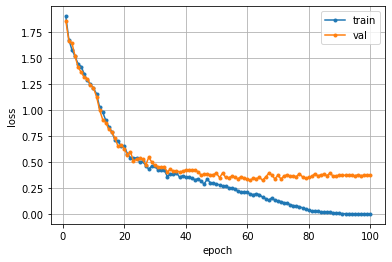

In [42]:
plot_history_train_val(history, 'loss')

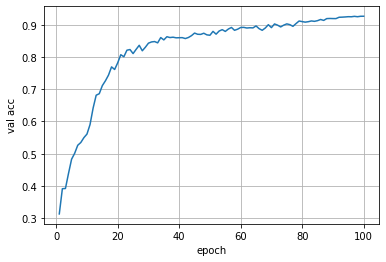

In [43]:
plot_history(history, 'val acc')